## Presentation

### Observations about the problem

- This problem is characterized by its vast state space and the scarcity of the reward that exists only when reaching the solved state if we don't introduce knowledge into the model. We could potentially introduce at one point a reward function that gives information about the quality of the current state.

- The system is deterministic and we know all the transitions of it. 

### We decide for now to not introduce any knowledge and have a reward of 1 if reaching the solved state and -1 else


### Important points on why we can't simply do Q Learning with this method:

1) We need the initial position to be close to the solved state else it will be impossible for the agent to get to this state (the only one giving a reward) given the extremely vast state space.
    -> We take as a distance to the solved state the number of random shuffles that are done from it.

2) The system is completely deterministic and we know all the transitions. It is thus better to work by updating the state_values instead of the q_values as it is 6x smaller (6 actions possible for a 2x2 rubiks cube).

3) We can't do full episodes as if the agent explores / goes into an unseen part of the rubiks cube he is very likely to get "lost" in it and do thousands of iterations before arriving to the solved state if it even reaches it. 



### The solution ADI (Auto Didactic Iteration) (https://arxiv.org/pdf/1805.07470.pdf)

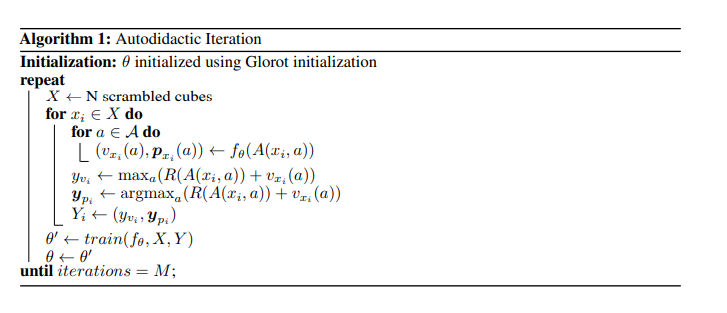

## Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Callable
from cube import CubeEnv

In [2]:
# Setup cuda/cpu device
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
#device=torch.device("cpu")
print(f"PyTorch will train neural networks on {device}")

False
PyTorch will train neural networks on cpu


## Environment

In [3]:
env = CubeEnv(device=device,render_mode="rgb_array")
env.reset()
states = [env.state]
for i in range(10):
    env.step(env.action_space.sample())
    states.append(env.state)
#env.animate_frames(states)

Simple checks made to check that rotations work and that they are able to cancel each other when performed successively. Reward function can also be checked here

Reward with 2 solves faces: -0.4
Reward of solved cube: 0.7999999999999998


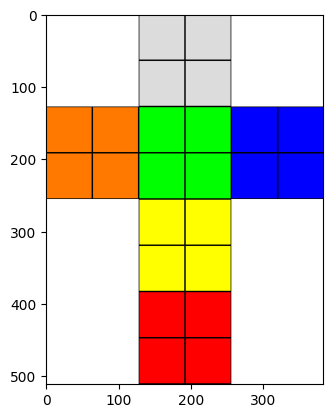

In [4]:
env.reset()
env._face_rotation(0, 1)
print("Reward with 2 solves faces:", env.reward(env.state))
env._face_rotation(0, -1)
print("Reward of solved cube:", env.reward(env.state))
env.render()

## DNN-Based Controler

In [5]:
n_input  = 6 * 6 * env.size * env.size # 6 = nombre de faces // size^2 = nombre de couleurs par face // 6 = one-hot encoding des couleurs
n_dense  = 256 # au pif, un pax avait choisi 1024 pour le 3x3

class ADINetwork(torch.nn.Module):
    def __init__(self):
        super(ADINetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, n_dense)
        self.l2=nn.Linear(n_dense, n_dense)
        self.l3 = nn.Linear(n_dense, 1)
        self.l4 = nn.Linear(n_dense, 6)
        self.softmax = nn.Softmax(dim=1)
        self.elu = nn.ELU()
        self.batch_norm = nn.InstanceNorm1d(n_dense)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.elu(x)
        x = self.l2(x)
        x= self.batch_norm(x)
        x = self.elu(x)
        x1 = self.l3(x)
        x1 = self.elu(x1)
        x2 = self.l4(x)
        #x2=self.softmax(x2)
        x = torch.cat((x1, x2), 1)
        return x

## Policies

ADI does not make use of any policy. It is only being used after the training phase, when trying to solve the cube

In [6]:
class GreedyPolicy :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,max_iter=20):
        self.adi_network = adi_network
        self.env=env
        self.max_iter=max_iter
    def __call__(self) -> int:
        states=[self.env._get_obs()]
        actions=[]
        for i in range(self.max_iter) :
            with torch.no_grad():
                action=torch.argmax(self.adi_network(self.env._get_obs().unsqueeze(0))[0][1:]).item()
            _,_,done,_,_=self.env.step(action)
            states.append(self.env._get_obs())
            actions.append(action)
            if done:
                break
        return done,states,actions

In [7]:
class BeamSearch :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,beam_width:int,max_iter=20):
        self.adi_network = adi_network
        self.beam_width=beam_width
        self.env=env
        self.max_iter=max_iter
    
    def __call__(self) -> int:
        considered_states=[(1,env._get_obs().unsqueeze(0),[],[])]
        depth=0
        while True:
            new_considered_states=[]
            for score,state,past_states,past_actions in considered_states :
                probas=torch.nn.Softmax()(self.adi_network(state)[0][1:])
                for i,proba in enumerate(probas) :
                    next_state_tensor,reward,done,_,_ =env.simulate_step(state.squeeze(),i)
                    next_state_tensor=next_state_tensor.unsqueeze(0)
                    state_to_consider=(score*proba.item(),next_state_tensor,past_states+[state],past_actions+[i])
                    new_considered_states.append(state_to_consider)
                    if done or depth==self.max_iter:
                        return done,state_to_consider[2]+[state],state_to_consider[3]+[i]
            depth+=1
                    
            #We keep only the beam_width best states
            considered_states=sorted(new_considered_states,key=lambda x : x[0],reverse=True)[:self.beam_width]

In [8]:
class UCB :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,confidence:float,max_iter=20):
        self.adi_network = adi_network
        self.env=env
        self.max_iter=max_iter
        self.confidence=confidence
        

    def __call__(self) -> int:
        #Here we define a node by the actions that were taken to arrive to it
        visits={(0,):1}
        values={}
        t=0
        while True :
            actions=[0]
            states=[self.env._get_obs()]
            done=False
            #One pass through the tree
            #Start at the root
            while not self._is_leaf(actions,visits) and not done:
                visits[tuple(actions)]+=1
                action_ucb=[]
                for next_action in range(6) :
                    updated_actions=tuple(actions+[next_action])
                    value_term=values[updated_actions]
                    exploratory_term=self.confidence*np.sqrt(np.log(t)/(1+visits[updated_actions]))
                    action_ucb.append(value_term+exploratory_term)
                next_action=np.argmax(action_ucb)
                actions.append(next_action)
                next_state,_,done,_,_=self.env.simulate_step(states[-1],next_action)
                states.append(next_state)

            if len(actions)==self.max_iter or done:
                return done,states,actions
            #When arriving at a leaf node, we explore it
            with torch.no_grad() :
                next_action_values=self.adi_network(states[-1].unsqueeze(0))[0][1:]
            
            for next_action in range(6) :
                updated_actions=tuple(actions+[next_action])
                values[updated_actions]=next_action_values[next_action].item()
                visits[updated_actions]=1
            visits[updated_actions]+=1
            t+=1
            if t>100:
                return False,[],[]
        

    def _is_leaf(self, actions,visits) :
        return tuple(actions+[0]) not in visits

## Learning rate scheduler

In [9]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

## Train function

In [10]:
class TargetValue:
    def __init__(self, adi_network: torch.nn.Module):
        self.adi_network = adi_network

    def __call__(self, env: CubeEnv,states:torch.tensor=None) -> np.int64:
        batch_size = states.shape[0]
        batched_action = torch.zeros(states.shape[0],dtype=torch.int64,device=device)
        batched_values = torch.zeros(states.shape[0],7,device=device)
        for i in range(batch_size):
            state_tensor=states[i]
            state=env.from_tensor_to_state(state_tensor)
            state_values = []
            for a in range(6) :
                next_state_tensor,reward,_,_,_ =env.simulate_step(state,a)
                next_state_tensor=next_state_tensor.unsqueeze(0)
                with torch.no_grad():
                    state_values.append(reward+self.adi_network(next_state_tensor)[0][0])
            state_values=torch.tensor(state_values,device=device)
            action = torch.argmax(state_values).item()
            batched_action[i]=action
            value=torch.zeros(7)
            value[action+1]=1
            value[0]=state_values[action]
            batched_values[i]=value
        return batched_values

In [11]:
def train_adi(env: CubeEnv,
                     adi_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     state_loss_fn: Callable,
                     action_loss_fn: Callable,
                     target_value_gen: TargetValue,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     batch_size: int,
                     n_episodes,
                     max_moves: int, #How deep we shuffle the rubiks cube
                     ) -> List[float]:

    losses = []

    for n_moves in range(1, max_moves + 1):
        print('Training on', str(n_moves) + '-shuffles for', n_episodes, 'episodes')
        for episode in tqdm(range(0, n_episodes, batch_size)) :
            env.reset()
            states = env.batch_shuffle(n_moves, batch_size=batch_size)
            loss = 0
            
            # The first dimension of states corresponds to the shuffle steps (n_moves, batch_size, n_input)
            for n_moves_samples, samples in enumerate(states) :
                target_value = target_value_gen(env, samples)
                estimated_value = adi_network(samples)
                # Rescaling by 1 / (n_moves_samples + 1) to avoid divergence of the value esimation.
                # Weight of 0.3 for the value_loss (= Estimation of the value of the state)
                # Weight of 0.7 for the action_loss (= Estimation of the action to take)
                loss +=  0.3 / (n_moves_samples + 1) * state_loss_fn(estimated_value[:,0], target_value[:,0]) + 0.7 * action_loss_fn(estimated_value[:,1:], target_value[:,1:])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            losses.append(loss.item() / n_moves)
            print(f"Episode {episode} - Loss: {losses[-1]} - {estimated_value[0][0]} - {target_value[0][0]}")
    
    return losses

## Train the model

In [25]:
shuffle_depth = 8
batch_size    = 256
num_episodes  = batch_size * 50
adi_network   = ADINetwork().to(device) # adi network
model_name    = "models/adi_network_hk_3.pth"

optimizer = torch.optim.AdamW(adi_network.parameters(), lr=0.01, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
state_loss_fn = torch.nn.MSELoss()
action_loss_fn = torch.nn.CrossEntropyLoss()
target_value = TargetValue(adi_network=adi_network)


# Train the adi network
losses = train_adi(env,adi_network,optimizer,state_loss_fn,action_loss_fn,target_value,device,lr_scheduler,batch_size,num_episodes,shuffle_depth)


# Save the action-value estimation function
torch.save(adi_network, model_name)

  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\cympe\git\INF581_Cube\cube.py:392: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(batched_obs, device=self.device)
c:\Users\cympe\git\INF581_Cube\venv\lib\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Episode 0 - Loss: 1.7016397714614868 - -0.22579216957092285 - 0.7903896570205688
Episode 256 - Loss: 1.0046782493591309 - 6.566978931427002 - 7.569156169891357
Episode 512 - Loss: 0.9715250730514526 - 8.684060096740723 - 9.623579978942871
Episode 768 - Loss: 0.7961863279342651 - 10.206191062927246 - 11.248260498046875
Episode 1024 - Loss: 0.798520565032959 - 11.684452056884766 - 12.752432823181152
Episode 1280 - Loss: 0.7719118595123291 - 13.250129699707031 - 14.240918159484863
Episode 1536 - Loss: 0.7379541397094727 - 14.73197078704834 - 15.769583702087402
Episode 1792 - Loss: 0.6872219443321228 - 16.2060546875 - 17.30941390991211
Episode 2048 - Loss: 0.6755476593971252 - 17.517160415649414 - 18.8333740234375
Episode 2304 - Loss: 0.6766619086265564 - 19.137115478515625 - 20.33129119873047
Episode 2560 - Loss: 0.6783372163772583 - 20.40748405456543 - 21.81014060974121
Episode 2816 - Loss: 0.6727269291877747 - 22.07235336303711 - 23.26593780517578
Episode 3072 - Loss: 0.6484899520874023

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.6573048830032349 - 57.07847595214844 - 56.761375427246094
Episode 256 - Loss: 0.6233600378036499 - 57.645748138427734 - 57.22053146362305
Episode 512 - Loss: 0.6356152296066284 - 58.01238250732422 - 57.656429290771484
Episode 768 - Loss: 0.6479789018630981 - 58.71074676513672 - 58.07284927368164
Episode 1024 - Loss: 0.6776512861251831 - 58.91434097290039 - 58.46833419799805
Episode 1280 - Loss: 0.614169716835022 - 59.21140670776367 - 58.76667785644531
Episode 1536 - Loss: 0.6671217679977417 - 59.5625 - 59.21438217163086
Episode 1792 - Loss: 0.6197036504745483 - 59.70448684692383 - 59.41061782836914
Episode 2048 - Loss: 0.6077373027801514 - 60.090370178222656 - 59.82505416870117
Episode 2304 - Loss: 0.6357811689376831 - 60.56045150756836 - 60.17145538330078
Episode 2560 - Loss: 0.6196311712265015 - 61.380882263183594 - 60.57648468017578
Episode 2816 - Loss: 0.6548349857330322 - 61.2060661315918 - 60.89651107788086
Episode 3072 - Loss: 0.6304498910903931 - 61.66104125

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.6311496098836263 - 66.49421691894531 - 67.91639709472656
Episode 256 - Loss: 0.6406430800755819 - 67.54293823242188 - 67.72990417480469
Episode 512 - Loss: 0.6529445648193359 - 68.2392349243164 - 68.17554473876953
Episode 768 - Loss: 0.7185222307840983 - 69.4259033203125 - 70.4879150390625
Episode 1024 - Loss: 0.6297509670257568 - 68.18221282958984 - 68.0642318725586
Episode 1280 - Loss: 0.6593432426452637 - 68.45796966552734 - 68.14755249023438
Episode 1536 - Loss: 0.6495173772176107 - 66.83795166015625 - 68.21713256835938
Episode 1792 - Loss: 0.6296598513921102 - 69.72733306884766 - 70.87305450439453
Episode 2048 - Loss: 0.6262426773707072 - 69.07073211669922 - 68.60440063476562
Episode 2304 - Loss: 0.623066226641337 - 69.87174224853516 - 71.04649353027344
Episode 2560 - Loss: 0.6245349248250326 - 69.47728729248047 - 69.10549926757812
Episode 2816 - Loss: 0.6323596239089966 - 67.89647674560547 - 69.15010833740234
Episode 3072 - Loss: 0.6313192844390869 - 69.643775

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.6850197315216064 - 71.65213775634766 - 70.90547180175781
Episode 256 - Loss: 0.644753098487854 - 71.85243225097656 - 70.9423599243164
Episode 512 - Loss: 0.6238440871238708 - 71.83914184570312 - 70.98136138916016
Episode 768 - Loss: 0.6380817294120789 - 69.78340911865234 - 70.65584564208984
Episode 1024 - Loss: 0.6582567691802979 - 71.77889251708984 - 70.968994140625
Episode 1280 - Loss: 0.6145973205566406 - 71.35685729980469 - 70.79987335205078
Episode 1536 - Loss: 0.658820390701294 - 72.23574829101562 - 71.51235961914062
Episode 1792 - Loss: 0.6519948840141296 - 71.68787384033203 - 71.53720092773438
Episode 2048 - Loss: 0.6104111671447754 - 71.46699523925781 - 71.1014175415039
Episode 2304 - Loss: 0.6499535441398621 - 71.70323181152344 - 71.5075912475586
Episode 2560 - Loss: 0.6058146953582764 - 71.34351348876953 - 71.52999114990234
Episode 2816 - Loss: 0.6318919658660889 - 71.15713500976562 - 70.87930297851562
Episode 3072 - Loss: 0.663329005241394 - 72.079521179

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.655479621887207 - 72.75559997558594 - 72.33032989501953
Episode 256 - Loss: 0.7000307083129883 - 72.74651336669922 - 71.89749145507812
Episode 512 - Loss: 0.6806429862976074 - 72.80834197998047 - 73.9434585571289
Episode 768 - Loss: 0.6641107559204101 - 72.67180633544922 - 72.0368881225586
Episode 1024 - Loss: 0.6730752944946289 - 71.83348846435547 - 71.87157440185547
Episode 1280 - Loss: 0.6794958591461182 - 72.85026550292969 - 71.92565155029297
Episode 1536 - Loss: 0.6869614124298096 - 72.95791625976562 - 71.98604583740234
Episode 1792 - Loss: 0.6621914863586426 - 71.9215316772461 - 71.74201202392578
Episode 2048 - Loss: 0.6572803497314453 - 73.05097198486328 - 72.1229476928711
Episode 2304 - Loss: 0.6823341846466064 - 73.0530776977539 - 72.07703399658203
Episode 2560 - Loss: 0.6583321571350098 - 72.89405059814453 - 72.1961441040039
Episode 2816 - Loss: 0.7041486740112305 - 72.75990295410156 - 71.71337127685547
Episode 3072 - Loss: 0.6780960083007812 - 72.38535308

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.7151945432027181 - 73.51187133789062 - 72.83963012695312
Episode 256 - Loss: 0.715404192606608 - 73.41780090332031 - 72.78407287597656
Episode 512 - Loss: 0.7146831353505453 - 73.29117584228516 - 73.29499053955078
Episode 768 - Loss: 0.7023945649464926 - 73.41634368896484 - 72.93030548095703
Episode 1024 - Loss: 0.7223714192708334 - 74.02196502685547 - 72.93370056152344
Episode 1280 - Loss: 0.7145142555236816 - 73.23413848876953 - 72.61676788330078
Episode 1536 - Loss: 0.7022589842478434 - 73.92204284667969 - 73.08770751953125
Episode 1792 - Loss: 0.672476053237915 - 73.30179595947266 - 72.96782684326172
Episode 2048 - Loss: 0.6891240278879801 - 73.71976470947266 - 73.04326629638672
Episode 2304 - Loss: 0.7086402575174967 - 73.75731658935547 - 73.00372314453125
Episode 2560 - Loss: 0.6703601678212484 - 73.93863677978516 - 73.51985931396484
Episode 2816 - Loss: 0.7011141777038574 - 73.95850372314453 - 73.53557586669922
Episode 3072 - Loss: 0.6726755301157633 - 73.485

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.7417928150721959 - 74.42115783691406 - 73.58541870117188
Episode 256 - Loss: 0.7309521266392299 - 73.4068374633789 - 73.44409942626953
Episode 512 - Loss: 0.6996923855372837 - 74.65472412109375 - 74.46819305419922
Episode 768 - Loss: 0.6915672166006905 - 74.62884521484375 - 73.68932342529297
Episode 1024 - Loss: 0.6903185844421387 - 74.06897735595703 - 73.94849395751953
Episode 1280 - Loss: 0.7285452570234027 - 74.25222778320312 - 73.96192169189453
Episode 1536 - Loss: 0.7066607475280762 - 74.78063201904297 - 73.87118530273438
Episode 1792 - Loss: 0.7429716246468681 - 73.67255401611328 - 73.8134765625
Episode 2048 - Loss: 0.7326044355119977 - 74.13664245605469 - 73.89371490478516
Episode 2304 - Loss: 0.7102116176060268 - 74.43701171875 - 73.88121795654297
Episode 2560 - Loss: 0.697713988167899 - 74.25405883789062 - 74.03437042236328
Episode 2816 - Loss: 0.7579130445207868 - 74.45368957519531 - 73.79520416259766
Episode 3072 - Loss: 0.7608486584254673 - 74.1688003540

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 - Loss: 0.7332545518875122 - 75.09549713134766 - 74.57261657714844
Episode 256 - Loss: 0.7345095872879028 - 75.39655303955078 - 74.52921295166016
Episode 512 - Loss: 0.7701854705810547 - 75.0070571899414 - 74.54512786865234
Episode 768 - Loss: 0.7322937846183777 - 75.09735107421875 - 74.65746307373047
Episode 1024 - Loss: 0.7358145117759705 - 75.50181579589844 - 74.69757080078125
Episode 1280 - Loss: 0.7412749528884888 - 75.8250732421875 - 74.70049285888672
Episode 1536 - Loss: 0.7421571016311646 - 75.09727478027344 - 74.5478515625
Episode 1792 - Loss: 0.7566059827804565 - 75.65384674072266 - 74.78633880615234
Episode 2048 - Loss: 0.7407593131065369 - 75.33307647705078 - 74.65853881835938
Episode 2304 - Loss: 0.7055090069770813 - 74.68465423583984 - 74.61975860595703
Episode 2560 - Loss: 0.7208595871925354 - 74.51152801513672 - 74.50963592529297
Episode 2816 - Loss: 0.7744482159614563 - 75.50170135498047 - 74.77887725830078
Episode 3072 - Loss: 0.7520681619644165 - 75.3382492

Execute the following code to load the pretrained model

In [12]:
# Load a pretrained model
adi_network = torch.load("models/adi_network_hk_3.pth", map_location=torch.device('cpu')).to(device)
#adi_network = torch.load("models/adi_network.pth").to(device)

Periodicity of the loss as we shuffle (from 1 shuffle to n shuffle and then back to 1 shuffle ...).

c:\Users\cympe\git\INF581_Cube\venv\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


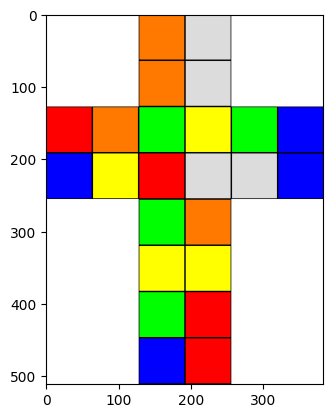

In [ ]:
beam_search = BeamSearch(adi_network, env, 10)
env.reset(9)
done, states, actions = beam_search()
#print(done, len(states), actions)
env.render()

TypeError: Image data of dtype object cannot be converted to float

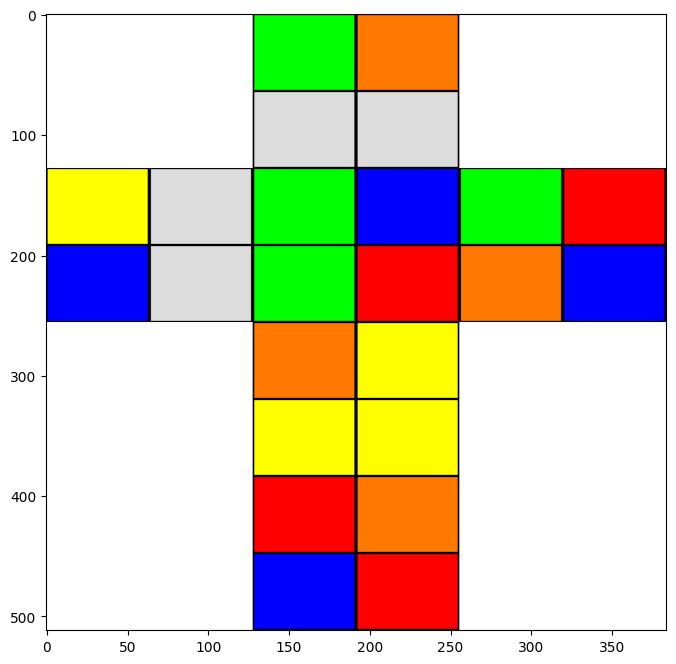

In [ ]:
env.animate_frames([env.from_tensor_to_state(state) for state in states])

## Accuracy metric
Accuracy is the percentage of n-shuffles of a cube an agent is capable of fully solving given a set number of moves before giving up. We calculate accuracy for a few policies with samples of 50 3-shuffles.

In [13]:
def compute_accuracy(env, n_samples, n_shuffles, policy) :
    success = 0
    for _ in range(n_samples):
        env.reset(n_shuffles)
        solved, _, _ = policy()
        if solved:
            success += 1
    return success / n_samples

def plot_accuracy(env, n_samples, max_shuffles, policies):
    for policy in policies:
        accs = []
        for i in tqdm(range(1, max_shuffles + 1)) :
            acc=compute_accuracy(env, n_samples, i, policy)
            accs.append(acc)
        plt.plot(list(range(1, max_shuffles + 1)), accs, label=policy.__class__.__name__)
        plt.xlabel("Number of shuffles")
        plt.ylabel("Accuracy")
        plt.title("Accuracy of various policies")
    
    plt.legend()
    plt.show()

Print accuracies of different policies on a sample of 50 different 3-shuffles

  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\cympe\git\INF581_Cube\venv\lib\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\cympe\git\INF581_Cube\venv\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/8 [00:00<?, ?it/s]

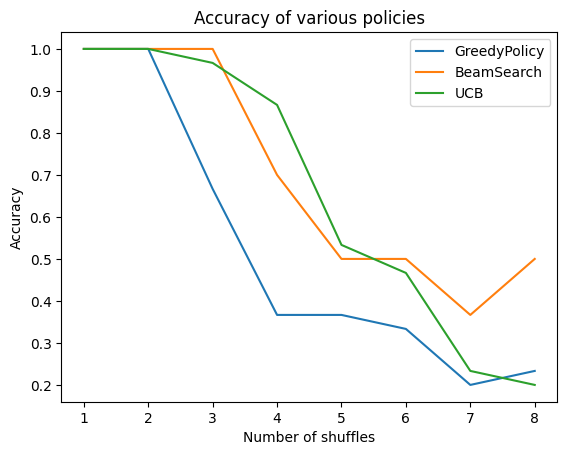

In [14]:
policies = [
    GreedyPolicy(adi_network, env),
    BeamSearch(adi_network, env, 10),
    UCB(adi_network, env, confidence=2),
]

plot_accuracy(env, 30, 8, policies)

Check the difference between a model trained with human knowledge based reward vs model without human knowledge. Test is made against a simple greedy policy with minimally trained models (1024 episodes, batch size of 8). Metrics on 1- up to 8-shuffles, samples of 100 shuffles.

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

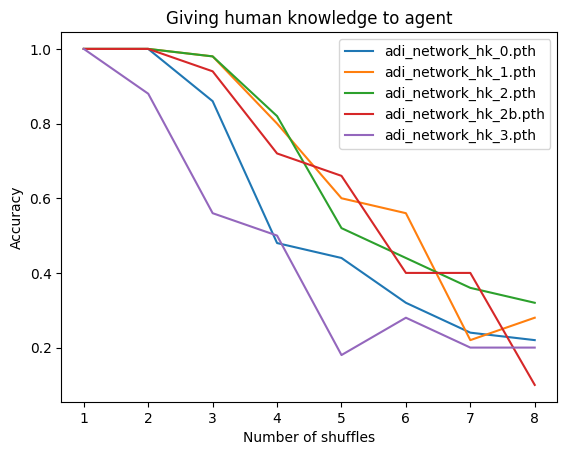

In [ ]:
n_samples = 50
max_shuffles = 8

for model_name in os.listdir('models'):
    if not model_name.startswith('adi_network_hk_'):
        continue

    adi_network = torch.load('models/' + model_name, map_location=torch.device('cpu')).to(device)
    policy = UCB(adi_network, env, confidence=2)
    
    accs = []
    for i in tqdm(range(1, max_shuffles + 1)):
        accs.append(compute_accuracy(env, n_samples, i, policy))
    plt.plot(list(range(1, max_shuffles + 1)), accs, label=model_name)

plt.xlabel("Number of shuffles")
plt.ylabel("Accuracy")
plt.title("Giving human knowledge to agent")
plt.legend()
plt.show() 